<a href="https://colab.research.google.com/github/ratul41907/Food-and-Nutrition-Based-RAG-Chatbot/blob/main/CSE445_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets polars

In [ ]:
from datasets import load_dataset

# Load the 'food' split
ds = load_dataset("openfoodfacts/product-database", split="food")

# Preview a few rows
print(ds[0])
print(ds.column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

food.parquet:   0%|          | 0.00/4.31G [00:00<?, ?B/s]

beauty.parquet:   0%|          | 0.00/49.7M [00:00<?, ?B/s]

Generating food split: 0 examples [00:00, ? examples/s]

Generating beauty split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/54 [00:00<?, ?it/s]

{'additives_n': None, 'additives_tags': None, 'allergens_tags': ['en:nuts'], 'brands_tags': ['xx:bovetti'], 'brands': 'Bovetti', 'categories': 'Petit-déjeuners,Produits à tartiner,Produits à tartiner sucrés,Pâtes à tartiner,Pâtes à tartiner aux noisettes,Pâtes à tartiner au chocolat,Pâtes à tartiner aux noisettes et au cacao', 'categories_tags': ['en:breakfasts', 'en:spreads', 'en:sweet-spreads', 'fr:pates-a-tartiner', 'en:hazelnut-spreads', 'en:chocolate-spreads', 'en:cocoa-and-hazelnuts-spreads'], 'categories_properties': {'ciqual_food_code': 31032, 'agribalyse_food_code': 31032, 'agribalyse_proxy_food_code': 31032}, 'checkers_tags': [], 'ciqual_food_name_tags': ['chocolate-spread-with-hazelnuts'], 'cities_tags': [], 'code': '0000101209159', 'compared_to_category': 'en:cocoa-and-hazelnuts-spreads', 'complete': 0, 'completeness': 0.6875, 'correctors_tags': ['openfoodfacts-contributors', 'tacite-mass-editor', 'sebleouf', 'moon-rabbit', 'roboto-app', 'timotheeberthault'], 'countries_tag

In [ ]:
from tqdm import tqdm
import pandas as pd

def extract_nutriments(item):
    nutriments_list = item.get('nutriments', None)
    nutriments = {}
    if nutriments_list and isinstance(nutriments_list, list):
        nutriments = {n['name']: n['value'] for n in nutriments_list if isinstance(n, dict) and 'name' in n and 'value' in n}
    return {
        "name": item.get("product_name", [{}])[0].get("text", "") if item.get("product_name") else "",
        "energy_kcal_100g": nutriments.get("energy-kcal", None),
        "fat_100g": nutriments.get("fat", None),
        "carbohydrates_100g": nutriments.get("carbohydrates", None),
        "sugars_100g": nutriments.get("sugars", None),
        "proteins_100g": nutriments.get("proteins", None)
    }

# Apply to dataset with progress bar
cleaned_data = [extract_nutriments(item) for item in tqdm(ds)]

# Create DataFrame
df = pd.DataFrame(cleaned_data)
print(df.head())

#DATAFRAME
#df.to_csv('food_cleaned.csv', index=False)           # Save as CSV
df.to_parquet('food_cleaned.parquet')                # Save as Parquet (recommended for large data)

print("Saved as food_cleaned.csv and food_cleaned.parquet")

100%|██████████| 4137197/4137197 [1:40:06<00:00, 688.74it/s]


                                                name  energy_kcal_100g  \
0  Véritable pâte à tartiner noisettes chocolat noir        617.000000   
1                               Chamomile Herbal Tea        280.000000   
2                     Lagg's, herbal tea, peppermint          0.000000   
3                                 Linden Flowers Tea        213.320007   
4                               Herbal Tea, Hibiscus        267.000000   

   fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  
0      48.0           36.000000         32.0       8.000000  
1       0.0           70.000000          NaN       0.000000  
2       0.0            1.470000          NaN       0.000000  
3       0.0           53.330002          NaN       0.000000  
4       0.0           60.000000          NaN      66.669998  
Saved as food_cleaned.csv and food_cleaned.parquet


In [ ]:
df.to_csv('food_cleaned.csv', index=False)
# or faster & smaller:
df.to_parquet('food_cleaned.parquet')

In [ ]:
import pandas as pd
df = pd.read_parquet("food_cleaned.parquet")

df.head()


,name,energy_kcal_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g
0,Véritable pâte à tartiner noisettes chocolat noir,617.000000,48.0,36.000000,32.0,8.000000
1,Chamomile Herbal Tea,280.000000,0.0,70.000000,NaN,0.000000
2,"Lagg's, herbal tea, peppermint",0.000000,0.0,1.470000,NaN,0.000000
3,Linden Flowers Tea,213.320007,0.0,53.330002,NaN,0.000000
4,"Herbal Tea, Hibiscus",267.000000,0.0,60.000000,NaN,66.669998


In [ ]:
from sklearn.model_selection import train_test_split

# Label: low calorie (<100 kcal/100g)
df['low_calorie'] = df['energy_kcal_100g'] < 100

# Features
X = df[['fat_100g', 'carbohydrates_100g', 'proteins_100g']].fillna(0)
y = df['low_calorie']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.9619851590447646


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred))

# Assuming binary classification and sklearn returns:
#     [[TN, FP],
#      [FN, TP]]

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Confusion Matrix:
 [[669543   8534]
 [ 22921 126442]]
              precision    recall  f1-score   support

       False       0.97      0.99      0.98    678077
        True       0.94      0.85      0.89    149363

    accuracy                           0.96    827440
   macro avg       0.95      0.92      0.93    827440
weighted avg       0.96      0.96      0.96    827440

True Positives (TP): 126442
True Negatives (TN): 669543
False Positives (FP): 8534
False Negatives (FN): 22921


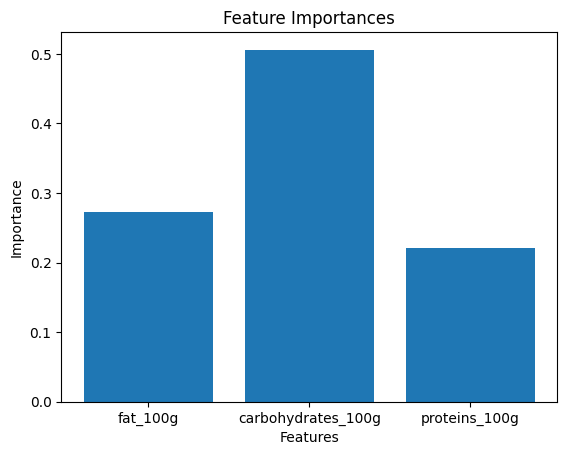

In [ ]:
import matplotlib.pyplot as plt

plt.bar(X_train.columns, clf.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()


In [ ]:
selected_features = ['fat_100g', 'carbohydrates_100g']

X_sel = df[selected_features].fillna(0)
y = df['low_calorie']

X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=42
)

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)

print("Accuracy (selected features):", clf_sel.score(X_test_sel, y_test))


Accuracy (selected features): 0.9368570530793774


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_sel = clf_sel.predict(X_test_sel)
print(confusion_matrix(y_test, y_pred_sel))
print(classification_report(y_test, y_pred_sel))

[[659658  18419]
 [ 33828 115535]]
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    678077
        True       0.86      0.77      0.82    149363

    accuracy                           0.94    827440
   macro avg       0.91      0.87      0.89    827440
weighted avg       0.94      0.94      0.94    827440



In [ ]:
import joblib

joblib.dump(clf_sel, "low_calorie_classifier_selected.joblib")
print("Saved reduced model.")


Saved reduced model.


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import itertools, os
import joblib

df = pd.read_parquet("food_cleaned.parquet")

selected_features = ['fat_100g', 'carbohydrates_100g']
X = df[selected_features].fillna(0)
y = df['energy_kcal_100g'] < 100

X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Import necessary libraries
import pandas as pd
import os
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import joblib

# --- 1. Define Parameter Grid ---
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Generate all combinations of the hyperparameters
param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split']
))

# File to store grid search progress
progress_file = "grid_search_results.csv"
# --- 2. Load Previous Results (if exists) ---
if os.path.exists(progress_file):
    prev = pd.read_csv(progress_file)
    done = set(tuple(x) for x in prev[['n_estimators','max_depth','min_samples_split']].values)
    results = prev.to_dict('records')
    print(f"Loaded {len(results)} previous results.")
else:
    done = set()
    results = []
# --- 3. Grid Search Loop ---
for n, d, s in tqdm(param_combinations, desc="Grid Search Progress"):
    if (n, d, s) in done:
        continue

    # Create the RandomForest model with current hyperparameters
    model = RandomForestClassifier(
        n_estimators=n,
        max_depth=d,
        min_samples_split=s,
        random_state=42,
        n_jobs=-1
    )

    # Perform cross-validation and calculate mean score
    scores = cross_val_score(model, X_train_sel, y_train, cv=3, scoring='accuracy')
    mean_score = scores.mean()

    # Append results to the list
    results.append({
        'n_estimators': n,
        'max_depth': d,
        'min_samples_split': s,
        'mean_score': mean_score
    })

    # Save the results to CSV after each iteration
    pd.DataFrame(results).to_csv(progress_file, index=False)
# --- 4. Extract Best Hyperparameters ---
df_results = pd.DataFrame(results)

# Find the best hyperparameters based on mean score
best = df_results.iloc[df_results['mean_score'].idxmax()]

print("Best Params:")
print(best)
# --- 5. Final Model Training and Saving ---
final_model = RandomForestClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=None if pd.isna(best['max_depth']) else int(best['max_depth']),
    min_samples_split=int(best['min_samples_split']),
    random_state=42,
    n_jobs=-1
)

# Train the model with the full training data
final_model.fit(X_train_sel, y_train)

# Save the best model to disk
joblib.dump(final_model, "best_rf_model.joblib")
print("Saved best model as best_rf_model.joblib")
